In [1]:
%run MCTS.ipynb
%run NNet_architecture.ipynb
%run Deck.ipynb
%run Board.ipynb
import time
from tensorflow.keras.models import load_model
import pickle
import os

In [2]:
model = create_model()
# model = load_model("models/latest.h5")

In [3]:
new_board = Board(deck)
root = MonteCarloTreeSearchNode(model, new_board, prior=0)

### Training

In [4]:
nb_simulations = 200
nb_games = 10
max_move_per_game = np.inf

In [58]:
node = root
games = [MonteCarloTreeSearchNode(model, Board(deck), prior=0) for i in range(nb_games)]
game = 0
i = 0
board_states = []
values = []
policies = []

while game < nb_games:
    node = games[game]
    i = 0
    while not node.board.is_game_over() and i < max_move_per_game:
        node.simulate(nb_simulations)
        
        l = [(ind, node._number_of_visits) for ind, node in node.children.items()]
        ind, action = max(l, key = lambda x:x[1])
        
        policy = np.zeros(5 * 5 * 52)
        total_visits = sum([b._number_of_visits for b in node.children.values()])
        for a, b in node.children.items():
            policy[a] = b._number_of_visits/total_visits
        
        policies.append(policy)
        board_states.append(node.board.board_state)
        values.append(node.mean_value()[0][0])
        
        # nodes.append(node)
        node = node.children[ind]
        
        plt.imshow(node.board.board_2D)
        plt.show()
        i += 1
        print("-----------", i)
    game +=1
    print("---------------------------------", game, "---------------------------------")

0


ZeroDivisionError: division by zero

In [35]:
def load_data(model_name, nb_simulations):
    
    with open(f'self_games/{model_name}/{nb_simulations}_simu_board_states.pickle', 'rb') as handle:
        board_states = pickle.load(handle)
    with open(f'self_games/{model_name}/{nb_simulations}_simu_policies.pickle', 'rb') as handle:
        policies = pickle.load(handle)
    with open(f'self_games/{model_name}/{nb_simulations}_simu_values.pickle', 'rb') as handle:
        values = pickle.load(handle)
    with open(f'self_games/{model_name}/{nb_simulations}_simu_nb_games.pickle', 'rb') as handle:
        nb_games = pickle.load(handle)
            
    return board_states, policies, values, nb_games

In [31]:
def self_play(model, model_name, root, nb_simulations=200, nb_games=2, max_move_per_game=np.inf):
    
    games = [MonteCarloTreeSearchNode(model, Board(deck), prior=0) for i in range(nb_games)]
    game = 0
    i = 0
    board_states = []
    values = []
    policies = []
    
    while game < nb_games:
        node = games[game]
        i = 0
        while not node.board.is_game_over() and i < max_move_per_game:
            node.simulate(nb_simulations)

            l = [(ind, node._number_of_visits) for ind, node in node.children.items()]
            ind, action = max(l, key = lambda x:x[1])

            policy = np.zeros(5 * 5 * 52)
            total_visits = sum([b._number_of_visits for b in node.children.values()])
            for a, b in node.children.items():
                policy[a] = b._number_of_visits/total_visits

            policies.append(policy)
            board_states.append(node.board.board_state)
            values.append(node.mean_value()[0][0])

            # nodes.append(node)
            node = node.children[ind]

            plt.imshow(node.board.board_2D)
            plt.show()
            i += 1
            print("-----------", i)
        game +=1
        print("-----------------------------------------", game, "-----------------------------------------")

    if not os.path.exists(f"self_games"):
        os.mkdir(f"self_games")
        
    if not os.path.exists(f"self_games/{model_name}"):
        os.mkdir(f"self_games/{model_name}")
        
    # Add the new generated game, policies, and values to old ones.
    if os.path.exists(f'self_games/{model_name}/{nb_simulations}_simu_board_states.pickle'):
        
        old_board_states, old_policies, old_values, old_nb_games = load_data(model_name, nb_simulations)

        board_states = old_board_states + board_states
        policies = old_policies + policies
        values = old_values + values
        nb_games = old_nb_games + nb_games
        
    with open(f'self_games/{model_name}/{nb_simulations}_simu_board_states.pickle', 'wb') as handle:
        pickle.dump(board_states, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(f'self_games/{model_name}/{nb_simulations}_simu_policies.pickle', 'wb') as handle:
        pickle.dump(policies, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(f'self_games/{model_name}/{nb_simulations}_simu_values.pickle', 'wb') as handle:
        pickle.dump(values, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(f'self_games/{model_name}/{nb_simulations}_simu_nb_games.pickle', 'wb') as handle:
        pickle.dump(nb_games, handle, protocol=pickle.HIGHEST_PROTOCOL) 


In [32]:
new_board = Board(deck)
root = MonteCarloTreeSearchNode(model, new_board, prior=0)

0


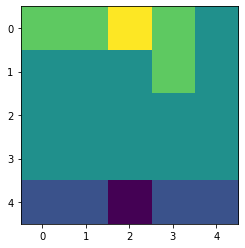

----------- 1
0


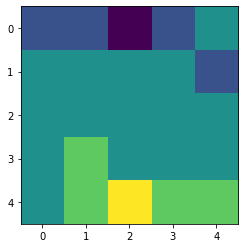

----------- 2
0


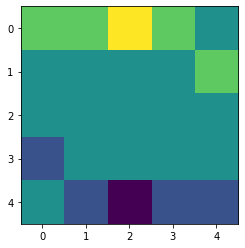

----------- 3
0


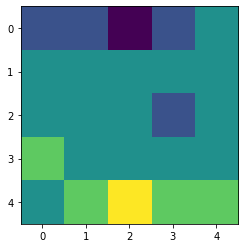

----------- 4
0


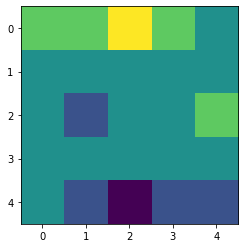

----------- 5
0


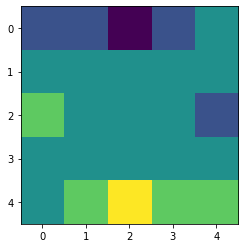

----------- 6
0


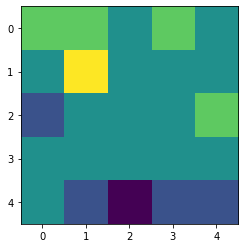

----------- 7
0


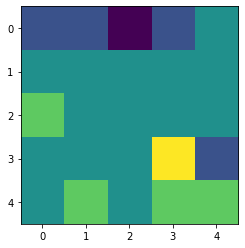

----------- 8
0


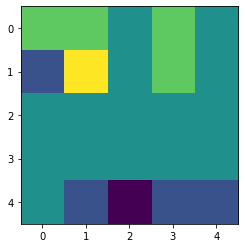

----------- 9
0


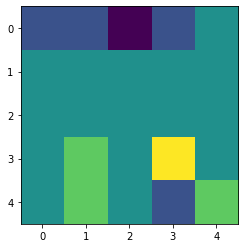

----------- 10
0


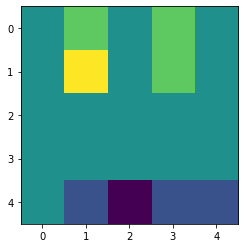

----------- 11
0


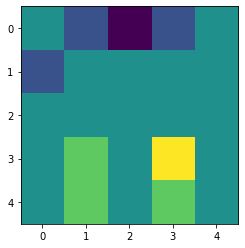

----------- 12
0


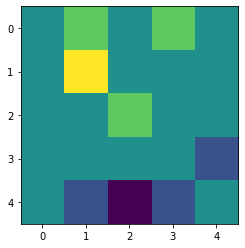

----------- 13
0


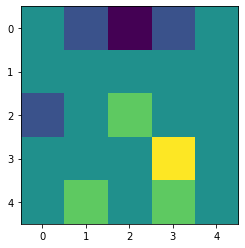

----------- 14
0


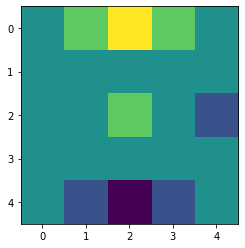

----------- 15
0


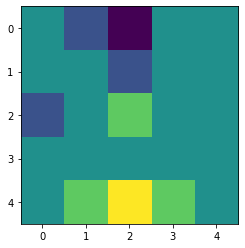

----------- 16
0


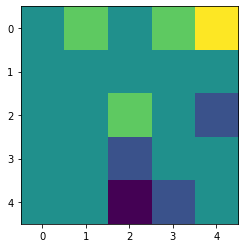

----------- 17
0


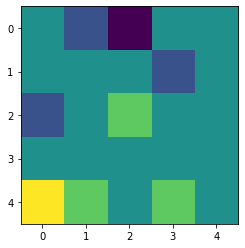

----------- 18
0


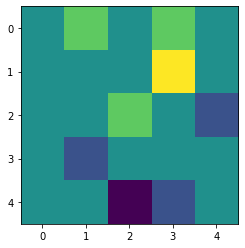

----------- 19
0


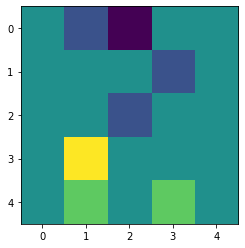

----------- 20
0


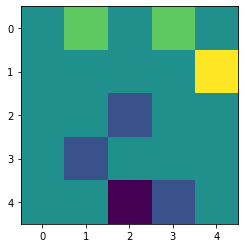

----------- 21
0


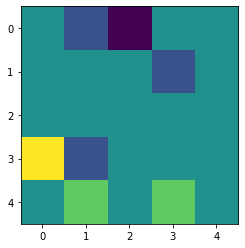

----------- 22
0


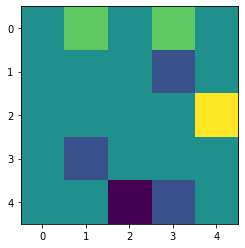

----------- 23
0


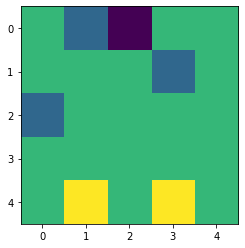

----------- 24
----------------------------------------- 1 -----------------------------------------
0


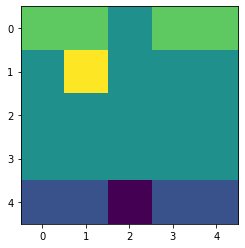

----------- 1
0


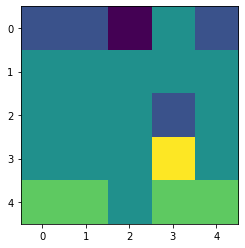

----------- 2
0


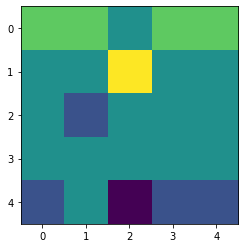

----------- 3
0


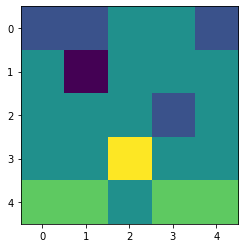

----------- 4
0


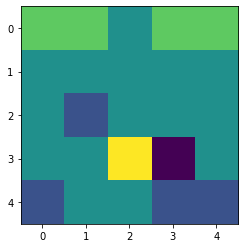

----------- 5
0


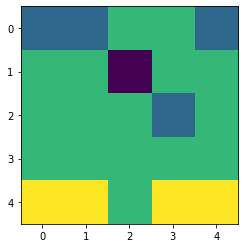

----------- 6
----------------------------------------- 2 -----------------------------------------
0


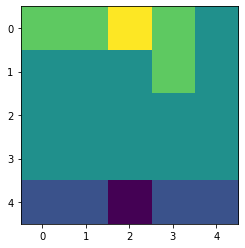

----------- 1
0


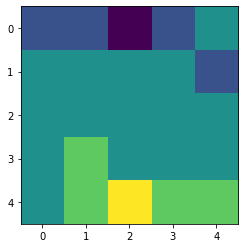

----------- 2
0


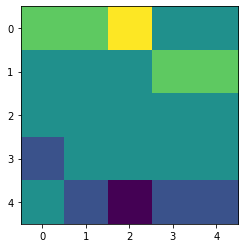

----------- 3
0


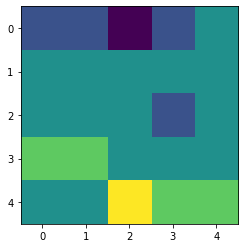

----------- 4
0


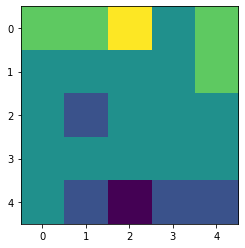

----------- 5
0


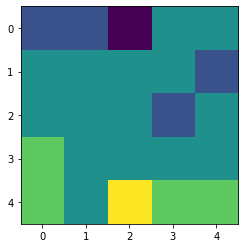

----------- 6
0


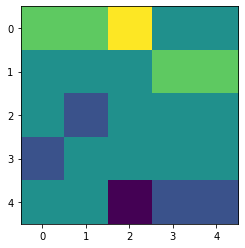

----------- 7
0


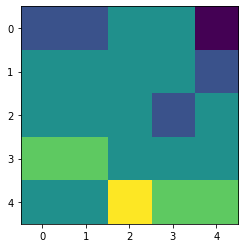

----------- 8
0


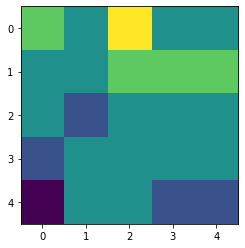

----------- 9
0


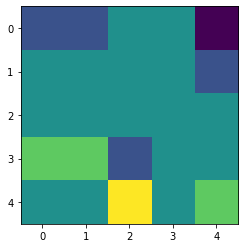

----------- 10
0


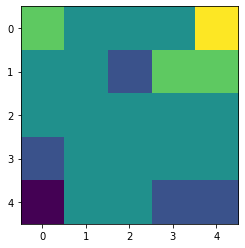

----------- 11
0


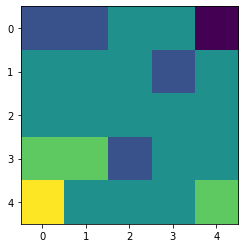

----------- 12
0


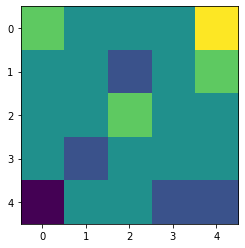

----------- 13
0


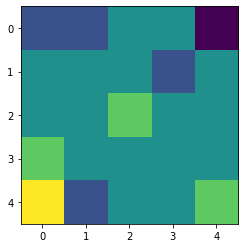

----------- 14
0


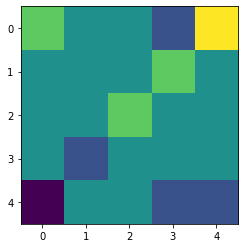

----------- 15
0


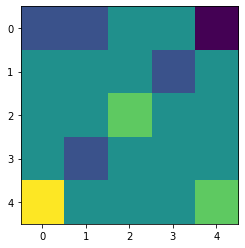

----------- 16
0


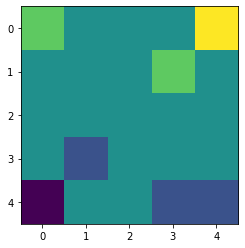

----------- 17
0


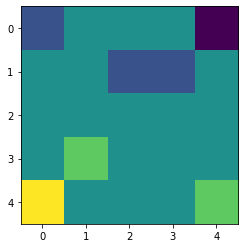

----------- 18
0


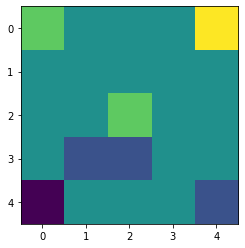

----------- 19
0


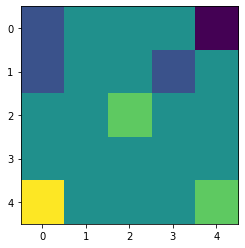

----------- 20
0


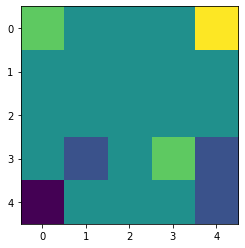

----------- 21
0


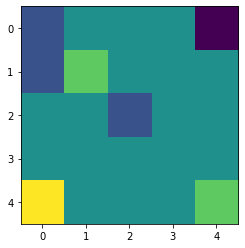

----------- 22
0


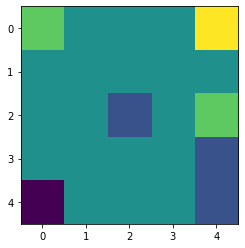

----------- 23
0


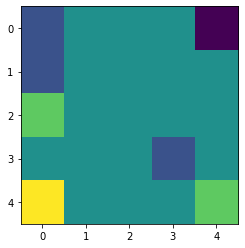

----------- 24
0


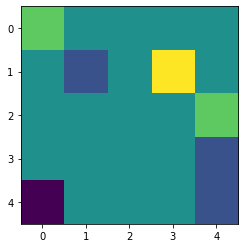

----------- 25
0


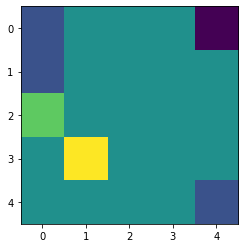

----------- 26
0


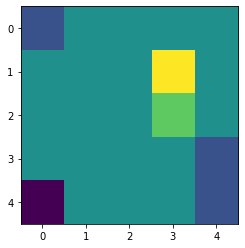

----------- 27
0


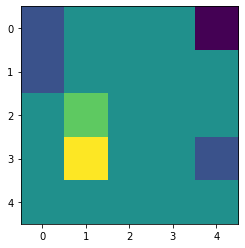

----------- 28
0


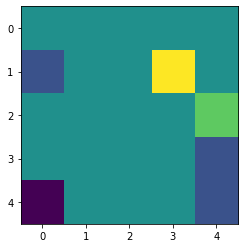

----------- 29
0


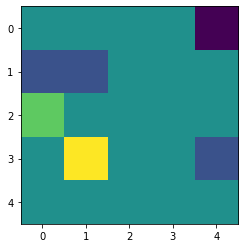

----------- 30
0


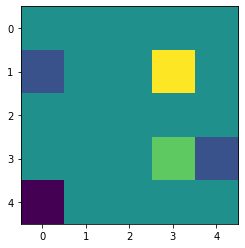

----------- 31
0


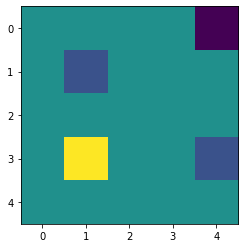

----------- 32
0


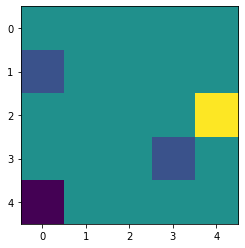

----------- 33
0


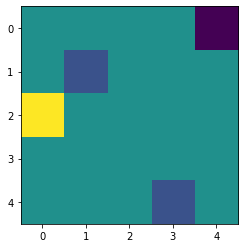

----------- 34
0


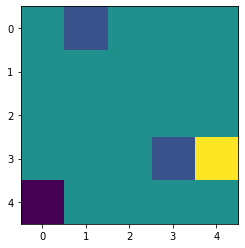

----------- 35
0


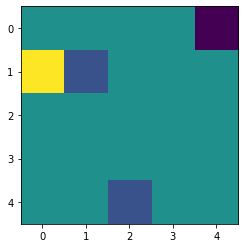

----------- 36
0


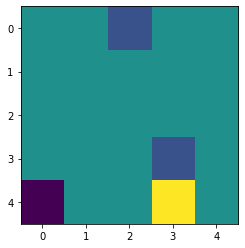

----------- 37
0


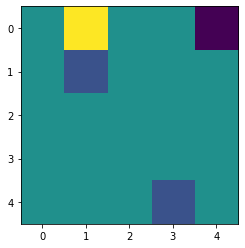

----------- 38
0


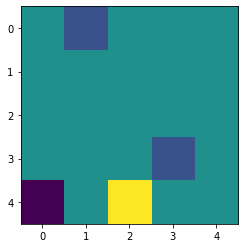

----------- 39
----------------------------------------- 3 -----------------------------------------


In [38]:
self_play(model, "model1", root, nb_simulations=2, nb_games=3)

# Train model

In [39]:
old_board_states, old_policies, old_values, old_nb_games = load_data("model1", 2)

In [ ]:
import pickle

a = board_states_2

with open('self_games/filename.pickle', 'wb') as handle:
    pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)


with open('self_games/filename.pickle', 'rb') as handle:
    b = pickle.load(handle)

print(a == b)

In [ ]:
board_states_2 = np.zeros((len(board_states), 5, 5, 10))
policies_2 = np.zeros((len(policies), 5, 5, 52))

for i, board in enumerate(board_states):
    
    board_states_2[i] = board
    policies_2[i] = policies[i].reshape((5, 5, 52))

In [ ]:
model.fit(board_states_2, [policies_2, np.array(values)], batch_size=256, epochs=15)

In [ ]:
import pandas as pd
pd.DataFrame(model.history.history).plot()

In [ ]:
#model.save("models/latest.h5")

# Tester avec un modèle plus simple ? 